# Instalación versión adeacuada de TensorFlow



In [1]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.17.0


In [3]:
!pip install tensorflow==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

In [4]:
import tensorflow as tf
print(tf.__version__)

2.14.0


#Imports necesarios

In [7]:
!pip install tflite_runtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 7.1 MB/s eta 0:00:00


In [8]:
from psutil import virtual_memory
from google.colab import drive
from pathlib import Path
import os #lectura o escritura en el sistema de archivos.
import matplotlib.pyplot as plt #proporciona una interfaz similar a MATLAB para la creación de gráficos y figuras.
import numpy as np #fundamental para la computación científica en Python, proporcionando soporte para matrices y operaciones matemáticas de alto rendimiento.
import tensorflow as tf #TensorFlow es una biblioteca de código abierto para el aprendizaje automático,
from tensorflow import keras #Keras es una API de alto nivel para construir y entrenar modelos de aprendizaje profundo.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import cv2
import json
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
import tflite_runtime.interpreter as tflite
from google.colab import files


#  Montaje del drive y organización de directorios



In [9]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [10]:
#Cambiar best_model por el nombre del modelo que queramos cargar
rutaModelo=Path('/content/gdrive/MyDrive/ColabNotebooks/newplantvillage/best_model.h5')

print(rutaModelo)

#Enlace con el modelo diponible ya entrenado
#https://drive.google.com/drive/u/1/folders/1OGTUW4Eu-AbdAPuwV4dWpjI7_es9QYnl

/content/gdrive/MyDrive/ColabNotebooks/newplantvillage/best_model.h5


# Configurar nuestro propio modelo y usar el modelo preentrenado ResNet50

In [11]:
# Cargar el modelo base ResNet50 preentrenado en ImageNet sin la parte superior
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Descongelar todas las capas del modelo base
base_model.trainable = True

# Crear un nuevo modelo
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(34, activation='softmax')  # 34 clases
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy']) #lr está obsoleto, hay que usar learning_rate


94765736/94765736 [==============================] - 4s 0us/step


# Obetener clases para la predición

In [12]:
rutaClases=Path('gdrive/My Drive/plantasIvan/newplantvillage')

print(rutaClases)

#Enlace disponible con las clases usadas
#https://drive.google.com/drive/folders/1hOImmBNjVnLyFUuxx65dqeo6ygJYnTjJ?usp=sharing

gdrive/My Drive/plantasIvan/newplantvillage


In [13]:
# Filtrar y ordenar los subdirectorios
classes_train = sorted(list(filter(lambda x: os.path.isdir('/content/gdrive/MyDrive/plantasIvan/newplantvillage/' + x), os.listdir('/content/gdrive/MyDrive/plantasIvan/newplantvillage/'))))


In [14]:
print(classes_train)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


# Cargar modelo ya entrenado (usar el de la ruta de Google Drive o el que entrenemos)

In [15]:
try:
    model = tf.keras.models.load_model(rutaModelo)
    print("Modelo cargado exitosamente")
except Exception as e:
    print(f"Error al cargar el modelo: {e}")


# Verificar la estructura del modelo
model.summary()

Modelo cargado exitosamente
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                            

# Para convertir tu modelo entrenado con tensorflow a tensorflow lite para posteriormente usarlo en tu proyecto y desplegarlo a un servidor y que esté no tenga un tamaño tan grande ejecuta está seccion

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [16]:
# Guardar el modelo convertido en un archivo .tflite
tflite_model_path = 'converted_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [19]:
# Descargar el archivo a tu PC
files.download(tflite_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Probar clasificación de imagenes

Crear una carpeta en el content llamada test_imgs y meter la imagen que deseamos predecir

In [20]:
# Prueba del modelo con imágenes propias
# Listar todas las imágenes en el directorio de pruebas
test_images = [f for f in os.listdir('/content/test_imgs/') if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.JPG')  or f.endswith('.jpeg')]
dataset = np.ndarray(shape=(len(test_images), 200, 200, 3))

# Cargar y redimensionar las imágenes
for i, file_name in enumerate(test_images):
    try:
        img_path = os.path.join('/content/test_imgs/', file_name)
        img = cv2.imread(img_path)
        if img is not None:
            img_resize = cv2.resize(img, (200, 200))
            dataset[i] = np.array(img_resize) / 255.0
        else:
            print(f"Error al cargar la imagen: {file_name}")
    except Exception as e:
        print(f"Error procesando la imagen {file_name}: {e}")

# Verificar las dimensiones del dataset
print("Shape del dataset:", dataset.shape)
print(f"Dimensiones de la imagen: {img_resize.shape}")

Shape del dataset: (1, 200, 200, 3)
Dimensiones de la imagen: (200, 200, 3)


1/1 [==============================] - 2s 2s/step


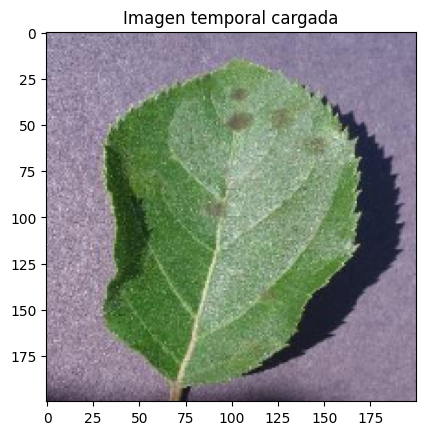

{'0a769a71-052a-4f19-a4d8-b0f0cb75541c___FREC_Scab 3165.JPG': 'Apple___Apple_scab'}


In [21]:


# Realizar predicciones utilizando el modelo
predictions = model.predict(dataset)
results = np.argmax(predictions, axis=-1)

# Verificar y mostrar la imagen temporal usando matplotlib (opcional)
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(img_resize, cv2.COLOR_BGR2RGB))
plt.title("Imagen temporal cargada")
plt.show()

# Construcción del diccionario de resultados
final_json = {}
for file_name, result in zip(test_images, results):
    final_json[file_name] = classes_train[result]

# Imprimir los resultados
print(final_json)
